# Red Neuronal desde Cero - Introducción a Keras

## Autor

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 



## Fork

## Referencias
1.  Jeremy Howard, Rachel Thomas and Francisco Ingham, <a href="https://jaredwinick.github.io/what_is_tf_keras/">What is tf.keras really?</a>


##  Introducción 

Este tutorial está basado en el tutorial <a href="https://jaredwinick.github.io/what_is_tf_keras/">What is tf.keras really?</a>  La lectura de datos no la haremos directamente de la URL usada por los autores, porque el archivo fue movido de allí. Usaremos los datos disponible en *tf.keras.dataset*.

## La base de datos MNIST 

El ejemplo que usaremos es la base de datos MNIST (Modified National Institute of Standards and Technology database), la cual está disponible libremente en diferentes sitios de internet, así como también desde los lenguajes de programación usados en el aprendizaje de máquinas. 


Esta es una base de datos de dígitos entre cero y uno digitalizados en escala de grises. Esto siginifica que cada punto de la imagen digitalizada es representada  mediante un byte. Esto siginifica que es posible representar 256 tonos de grises, con valores enteros entre 0 (blanco) hasta 255 (negro). Además, la base de datos contiene una etiqueta (label) para cada  imagen.

La siguiente imagen tomada de Wikipedia, muestra algunas de las imagenes de la base de datos MNIST.
  
    
<figure>
<center>
<img src="./Imagenes/MnistExamples.png" width="400" height="200" align="center"/>
</center>
<figcaption>
<p style="text-align:center">Imágenes de dígitos en la base de datos MNIST. Imagen tomada de Wikipedia</p>
</figcaption>
</figure>




Cada imagen tiene un tamaño de 28 x 28 pixeles, con lo cual cada una es representada por 784 números entre cero y 255. En el preprocesamiento las matrices de  28 x 28 números representando cada imagen son convertidas a arreglos unidimensionales de tamaño 784, colocandp una fila a continuación de la otra.  Este proceso es conocido como aplanamiento (flatened). 

Adicionalmente los arreglos son escalados dividiendo cada componente entre 255, para obtener valores entre cero y uno.

Por otro lado, las etiquetas serán recodificadas usando la codificación One-Hot-Encodding (dummy encodding) o  codificación 0-1. Es decir que cada etiqueta es representada por un arreglo de diez dígitos binarios, de los cuales todos son cero excepto uno. Por ejemplo si la etiqueta es 3, la codificación One-Hot-Encodding  será *0010000000*.

La base de datos MNIST tiene 60.000 imágenes marcadas para entrenamiento (training) y 10.000 para evaluación (testing).

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Versión de Tensorflow: ", tf.__version__)

Versión de Tensorflow:  2.1.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np

(x_train, y_train), (x_valid, y_valid) = tf.keras.datasets.mnist.load_data()

print("x_train.shape=",x_train.shape)
print(type(x_train))
print('x_train.dtype',x_train.dtype)

print("y_train.shape=",y_train.shape)
print(type(y_train))
print('y_train.dtype',y_train.dtype)

x_train.shape= (60000, 28, 28)
<class 'numpy.ndarray'>
x_train.dtype uint8
y_train.shape= (60000,)
<class 'numpy.ndarray'>
y_train.dtype uint8


Estos datos tiene formato de arreglos numpy. Tensorflow utiliza el formato tf.Tensor, por lo que es necesario transformar los datos a dicho formato.

In [3]:
# resize x
x_train.resize((60000,784)) # Change shape and size of array in-place.
x_valid.resize((10000,784))


# transform x to [0,1] scale and create constant tensors  
x_train = tf.constant(x_train/255., dtype= tf.float32)
x_valid = tf.constant(x_valid/255., dtype= tf.float32)


print("shape x_train = ",x_train.shape)
print("type x_train = ",x_train.dtype)
print("Min x_train = ",tf.reduce_min(x_train).numpy())
print("Max x_train = ",tf.reduce_max(x_train).numpy())

# transform y to int32 and create constant tensors
y_train = tf.constant(y_train,dtype=tf.int32)
y_valid = tf.constant(y_valid,dtype=tf.int32)

print("type y_train = ",y_train.dtype)
print("Min y_train = ",tf.reduce_min(y_train).numpy())
print("Max y_train = ",tf.reduce_max(y_train).numpy())

shape x_train =  (60000, 784)
type x_train =  <dtype: 'float32'>
Min x_train =  0.0
Max x_train =  1.0
type y_train =  <dtype: 'int32'>
Min y_train =  0
Max y_train =  9


Usamos *tf.constant* para declarar tensores constantes, es decir cuyo valor no cmabia a lo largo del algoritmo.  Note que se ha dividido x_train y x_valid entre 255, para transformar los datos a escala $[0.0,1.0]$. 

## Primera Imagen de la base de datos

La siguiente imagen corresponde al primer registro de la base de datos MNIST.

In [4]:
%matplotlib inline

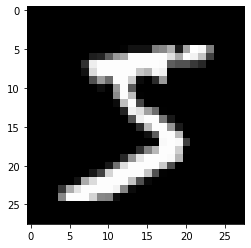

(60000, 784)
<class 'tensorflow.python.framework.ops.EagerTensor'>
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

In [5]:
plt.imshow(x_train[0].numpy().reshape((28,28)),cmap="gray")
plt.show()
print(x_train.shape)
print(type(x_train))
print(x_train[0].numpy())

## Diseño de la Red Neuronal Básica. Modelo Logístico Multinomial

El propósito de la red es clasificar cada una de las imágenes en una de 10 clases. Cada clase representa a un dígito entre 0 y 9.

En este experimento cada imagen será presentada a la entrada de la red como una tensor de una dimensión (1D) y de tamaño (shape) $28\times 28 = 784$. Por lo tanto, la capa entrada se tendran 784 neuronas. La red no tendrá capas ocultas. La capa de salida tendrá 10 neuronas, debido a que hay 10 clases.

El tipo de red será densa o completamente conectada, es  decir cada neurona de entrada está conectada con cada neurona de salida. 

Así, la matriz de pesos $\mathbf{W}$ tendrá tamaño $784 \times 10$ y el vector $\mathbf{b}$ de interceptos (bias) será de un vector tamaño 10.


En nuestro primer modelo, la función de activación de la capa de entrada será la identidad y en la capa de salida la función de activación será la función *softmax* que definimos abajo.

La siguiente imagen ilustra el diseño (topología) de la primera red que constriomos desde cero. Esta red, es realmente un modelo logístico multinomial clásico.




<figure>
<center>
<img src="./Imagenes/ANN_mnist_748_10.jpg" width="600" height="400" align="center"/>
</center>
<figcaption>
<p style="text-align:center">Topología de  la  red neuronal. Modelo Logístico Multinomial </p>
</figcaption>
</figure>

## La Red Neuronal desde cero (sin tf.keras) </h2>

Vamos a crear primero un modelo, para lo cual solamente usaremos las operaciones de Tensorflow.  Los pesos son inicializados siguiendo la propuesta de <a href='http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf'>Gorot_Bengio </a>. Se generaran números aleatorios y se divide por $\sqrt{n}$. 
 

In [6]:
import math

weights = tf.Variable(tf.random.normal((784,10))/math.sqrt(784), dtype= tf.float32)
bias = tf.Variable(tf.zeros(10),tf.float32)


Usamos  *tf.Variable* para declarar tensores de tipo variable, es decir, cuyo contenido cambia a los largo de nuestro algortimo.

### Racional

Por  otro lado, observe que *weights* es una matriz de tamaño $784 \times 10$ y *bias* es un vector de tamaño 10. Vamos a construir una red neuronal que tiene solamente dos capas: entrada con 784 neuronas y salida con 10 neuronas. Note que nuestros patrones de entrada son vectores de tamaño 748.

La razón de tener 10 neuronas de salida es porque tenemos un problema de clasificación en 10 clases. Podemos imaginar intuitivamente es que construimos un modelo de regresión logística para cada una de las clases. Entonces a la salida esperamos tener la probabilidad que el patron de entrada pertenezca a esa clase.

### Diferenciación Automática

Tensorflow 2.0 incluye **diferenciación automática** para calcular gradientes automáticamente. Esto permite usar funciones estándar de Python como modelos para la redes. 

### Función de Activación softmax

Vamos a crear un modelo lineal simple. Necesitaremos una función de activación, por lo que vamos a escribir la función *log_softmax*. La variable *eta* en la función, que corresponde al máximo de los valores, se introduce para tener una función muy robusta, desde el punto de vista computacional.

Para un conjunto de valores $x_1,\ldots,x_n$, la función softwax transforma estos valores en la escala (0,1), que pueden interpretarse como probabilidades. Cada componente de softmax es interpretada como la probabilidad que la imagen pertenezca a la clase representada por dicha componente.

Matemáticamente se escribe

$$
\begin{equation}
Prob[y=j|x] = \frac{\exp(x_j)}{\sum_{k=1}^{n}\exp(x_j)}
\end{equation}
$$

Un cálculo muy estable computacionalmente de estos valores se obtiene de la siguente manera. Sea $\eta = \underset{i}{\text{max}} \hspace{2mm} \{x_i\}$. Es fácil verificar que

$$
\begin{equation}
Prob[y=j|x] = \frac{\exp(x_j-\eta)}{\sum_{k=1}^{n}\exp(x_k-\eta)} = \text{softmax}_j(x)
\end{equation}
$$

Observe que $\log \text{softmax}_j(x)  = x_j - \eta - \log(\sum_{k=1}^n \exp(x_k-\eta))$.


In [7]:
def log_softmax(x):
    eta = tf.math.reduce_max(x)
    return x - eta - tf.math.log(tf.math.reduce_sum(tf.math.exp(x-eta), -1, keepdims=True))

def model(xb):
    return log_softmax(xb @ weights + bias) # z = x'W +b


En la celda anterior, el símbolo @ representa la operación del producto punto. Llamaremos a nuestra función con un lote de datos (en este caso, 64 imágenes). Este es un paso hacia adelante (forward pass). Tenga en cuenta que nuestras predicciones no serán mejores que aleatorias en esta etapa, ya que comenzamos con pesos aleatorios.


In [8]:
bs = 64 # batch size

xb = x_train[0:bs]
preds = model(xb) # predictions
print('Predicciones para la primera imagen: ',preds[0],'\n Tamaño de la matriz de predicciones de este lote: ', preds.shape)


Predicciones para la primera imagen:  tf.Tensor(
[-2.1273656 -2.1138806 -2.6305888 -2.537918  -2.732724  -1.9756156
 -2.4066586 -2.0980308 -2.3994372 -2.2855947], shape=(10,), dtype=float32) 
 Tamaño de la matriz de predicciones de este lote:  (64, 10)


### Función de pérdida

Vamos a implementar la función menos log-verosimilitud, la cual usaremos como **función de pérdida** (loss function). Esta es la misma **entropía cruzada**(cross entropy, usando la codificación One-hot).


Matemáticamente, la función de pérdida en esta caso es definida como sigue:



###  El Modelo

Aqui $\mathbf{x}_i$ denota la observación $i$. 

$$
\pi_{ik} = Prob[\mathbf{x} \in \mathcal{C}_k] = sofmax_k(\mathbf{x}_i) = \frac{\exp(\mathbf{x}_i'\mathbf{w}_k + \mathbf{b}_k)}{\sum_{s=1}^K  \exp (\mathbf{x}_i'\mathbf{w}_s+  \mathbf{b}_s)} 
$$


###  Función de pérdida 

En esta sección $\mathbf{W}$ es la martriz completa de pesos. Cada fila $\mathbf{w}_k$ está asociada a la respectiva categoría $\mathcal{C}_k$.

Entropía cruzada: **-log verosimilitud** .  Aqui $\mathbf{x}_i$ denota la observación $i$ y $y_i$ la respectiva etiqueta. Sea $\chi_{ik}$ definda por

$$
\chi_{ik} = \begin{cases} 1, & \text{ si } y_i = k\\
0, & \text{ en otro caso. }\end{cases}
$$


$$
loss(\mathbf{W},\mathbf{b}) = -\frac{1}{N}  \sum_i \sum_k \chi_{ik} \log \pi_{ik}
$$

### Predicción

$$
\tilde{y} = \text{índice}(\max_{k}{\pi_k(x)})
$$

###  Precisión

$$
\begin{equation*}
\text{accuracy} = \frac{1}{N} \sum_{i=1}^{N} 1_{y_i =\tilde{y}_i}
\end{equation*}
$$

In [9]:
def nll(input, target):
    indices = tf.stack([tf.range(input.shape[0], dtype=tf.int32),target], axis=1)
    return tf.math.reduce_mean(-tf.gather_nd(input, indices))

loss_func = nll


In [ ]:
# ejemplo del tensor indices
import pandas as pd
pattern = {'0': 0, '1': 1, '2':2, '3':3, '4':4}
target = {'0': 3, '1': 0, '2':5, '3':7, '4':1}
indices = pd.DataFrame({'pattern': pattern, 'target':target})
indices

Sobre el código anterior. 
1. *tf.range(input.shape[0])*  genera un tensor con números en el rango entre 0 y 63, porque la forma (shape) es 64, el tamaño del batch.
2. *tf.stack([tf.range(input.shape[0], dtype=tf.int32),target], axis=1)* crea un tensor bidimensional, en donde cada fila corresponde al índice del elemento que debe tomarse de cada fila de input para calcular la funcion de pérdida. Por ejemplo, si la fila 3 de índice es [3,4], significará que y_train[3] es 4, y ṕor tanto se requiere tomar el contenido de la cuarta posición de la entrada 3.
3. tf.gather_nd(input, indices). Para cada fila de input toma el valor de input en la posición indicada en el índice, como se explica en el numeral 2.
4. tf.math.reduce_mean(-tf.gather_nd(input, indices)), calcula el resumen. La media, que corresponde exáctamete a - log likelihood

Veámos una ilustración de índices. 

In [19]:
# ejemplo del tensor indices
import pandas as pd
pattern = {'0': 0, '1': 1, '2':2, '3':3, '4':4}
target = {'0': 3, '1': 0, '2':5, '3':7, '4':1}
indices = pd.DataFrame({'pattern': pattern, 'target':target})
indices

,pattern,target
0,0,3
1,1,0
2,2,5
3,3,7
4,4,1


la columna pattern en esta ilustración contiene el índice del respectivo patrón de entrada. La columna target es el target asociado al respectivo patrón de entrada. Indices es esta matriz con las dos columnas.

La última línea del código calcula la función de pérdida definida arriba.

Revisamos ahora la **función de pérdida** para el modelo con datos aleatorios. Esto permitirá comparar las mejoras después del paso de propagacion hacia atrás  (backpropagation)

In [10]:
yb = y_train[0:bs]
print(loss_func(preds,yb))

tf.Tensor(2.3694425, shape=(), dtype=float32)


También implementamos la función precisión (accuracy) de nuestro modelo.

In [11]:
def accuracy(out,yb):
    preds = tf.dtypes.cast(tf.math.argmax(out,axis=1), tf.int32)   # posición del valor máximo en cada arreglo
    return tf.math.reduce_mean(tf.dtypes.cast(preds==yb,tf.float16))


chequamos la precisión actual del modelo

In [12]:
print(accuracy(preds,yb))

tf.Tensor(0.0625, shape=(), dtype=float16)


### Entrenamiento de la Red
 
 Estamos listos para correr el ciclo de entranamiento. Para calcular los gradientes usaremos diferenciación automática, con la clase tf.GradientTape.
 
- Seleccionamos un mini-batch de datos de tamaño *bs*
- Bajo un contexto tf.GradientTape 
 - Usamos el modelo para hacer predicciones
 - Calculamos la pérdida
- Calculamos el gradientes de las operaciones registradas en el contexto de esta cinta (tape).

Ahora usamos estos gradientes para actualizar los pesos (weights) y los desplazamientos (bias).


In [13]:
lr = 0.2 # learning rate
epochs = 2 # how many epochs to train for
n = x_train.shape[0]

for epoch in range(epochs):
    for i in range((n-1)//bs +1):
        start_i = i*bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        with tf.GradientTape() as t:
            pred = model(xb)
            loss = loss_func(pred,yb)
        dW, dB = t.gradient(loss,[weights,bias])
        weights.assign_sub(lr*dW)
        bias.assign_sub(lr*dB)


Hemos creado y entrenado una red neuronal minimal( en este caso una regression logística multinomial, dado que no tiene capas ocultas) totalmwente desde cero (from scratch).

Revisemos la pérdida y precisión del modelo.

In [16]:
# pérdida y precisión datos de entrenamiento
print("train loss: ",loss_func(model(x_train),y_train))
print("train accuracy: ",accuracy(model(x_train),y_train))

# pérdida y precisión datos de validación
print("test loss: ",loss_func(model(x_valid),y_valid))
print("test accuracy: ",accuracy(model(x_valid),y_valid))

train loss:  tf.Tensor(0.30663186, shape=(), dtype=float32)
train accuracy:  tf.Tensor(0.911, shape=(), dtype=float16)
ttest loss:  tf.Tensor(0.30020323, shape=(), dtype=float32)
test accuracy:  tf.Tensor(0.9146, shape=(), dtype=float16)


## La Red Neuronal usando tf.keras

Ahora refactorizaremos nuestro código, para que haga lo mismo que antes, solo que comenzaremos a aprovechar las clases *tf.keras* de TensorFlow para hacerlo más conciso y flexible. En cada paso a partir de aquí, deberíamos hacer que nuestro código sea más corto, más comprensible y / o más flexible.

El primer y más fácil paso es acortar nuestro código reemplazando nuestras funciones de activación y pérdida escritas a mano con las de tf.keras.

TensorFlow proporciona una función única función *tf.keras.losses.SparseCategoricalCrossentropy* que combina una activación softmax con una función de pérdida. Tenga en cuenta que usamos from_logit = True aquí porque no estamos pasando una distribución de probabilidad

In [29]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

def model(xb):
    return xb @ weights + bias


In [30]:
print(loss_func(yb,model(xb)), accuracy(model(xb),yb))

tf.Tensor(0.09631616, shape=(), dtype=float32) tf.Tensor(0.9688, shape=(), dtype=float16)


### Refactorización usando tf.keras.Model 

A continuación, utilizaremos *tf.keras.Model* para un ciclo de entrenamiento más claro y conciso. Hacemos una subclase (heredamos) de la clase *tf.keras.Model* (que en sí mismo es una clase y puede realizar un seguimiento del estado). En este caso, queremos crear una clase que contenga nuestros pesos, sesgos y métodos para el paso adelante (forward pass).

In [31]:
class Mnist_logistic(tf.keras.Model):
    def __init__(self):
        super(Mnist_logistic,self).__init__()
        self.w = tf.Variable(tf.random.normal((784,10)) /math.sqrt(784))
        self.b = tf.Variable(tf.zeros(10))
    
    def call(self, xb):
        return xb @ self.w + self.b
    

Como ahora estamos usando un objeto en lugar de solo usar una función, primero tenemos que instanciar nuestro modelo:

In [32]:
model = Mnist_logistic()

Ahora podemos calcular la pérdida de la misma manera que antes. Tenga en cuenta que los objetos *tf.keras.Model* se usan como si fueran funciones (es decir, son invocables), pero detrás de escena TensorFlow llamará a nuestro método *call* automáticamente.

In [33]:
print(loss_func(yb,model(xb)))

tf.Tensor(2.3267632, shape=(), dtype=float32)


In [34]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs +1):
            start_i = i*bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            with tf.GradientTape() as t:
                pred = model(xb)
                loss = loss_func(yb, pred)
                
            gradients = t.gradient(loss, model.trainable_variables)
            for variable, grad in zip(model.trainable_variables, gradients):
                variable.assign_sub(lr * grad)
                
            

In [37]:
fit()

Chequeemos que la  pérdida ha descendido

In [38]:
print(loss_func(yb,model(xb)), accuracy(model(xb),yb))

tf.Tensor(0.07612533, shape=(), dtype=float32) tf.Tensor(0.9688, shape=(), dtype=float16)


In [39]:
xb.shape

TensorShape([32, 784])

### Refactorización usando tf.keras.layers.Dense 

Continuamos refactorizando nuestro código. En lugar de definir e inicializar manualmente *self.weights* y *self.bias*, y calcular *xb @ self.weights + self.bias*, en su lugar usaremos la clase TensorFlow *tf.keras.layers.Dense* para una capa lineal, que hace todo eso por nosotros. TensorFlow tiene muchos tipos de capas predefinidas que pueden simplificar enormemente nuestro código y, a menudo, también lo hacen más rápido.

In [41]:
class Mnist_Logistic(tf.keras.Model):
    def __init__(self):
        super(Mnist_Logistic,self).__init__()
        self.linear = tf.keras.layers.Dense(10, input_shape=(None,784))
        
    def call(self, xb):
        return self.linear(xb)
    

### La clase tf.keras.layers.Dense

La clase  [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) se deriva de la clase [tf.keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer). Cuando se crea una instancia de clase, se reserva el espacio y se preparan todos los objetos, funciones requeridos para implementar una capa de la red. 

En momento de ejecución la instancia recibe un tensor $(N\times D)$, en donde $N$ es el tamaño del batch y $D$ el tamaño de la entrada. En nuestro ejemplo, $(32 \times 784)$. A la salida de la capa entrega otro tensor de tamaño $N\times M$, en donde  $N$ es el tamaño del batch y $M$ el tamaño de la salida de la capa. En el ejemplo $(32 \times 10)$.

La instancia mantiene sus parámetros $\mathbf{W}$ y $\mathbf{b}$, los cuales son actualizados en el proceso de entrenamiento. Sin embargo, para que sean actualizados, los parámetros debe declararse como *trainable*, lo cual ocurre por defecto. 

Adicionalmente, es posible definir una función de activación para la capa y procedimientos de regularización.




###  Intanciar un objeto de clase  Mnist_Logistic

In [42]:
model = Mnist_Logistic()
print(loss_func(yb, model(xb)))

tf.Tensor(2.4284055, shape=(), dtype=float32)


Aun podemos usar el método fit como antes

In [43]:
fit()

print(loss_func(yb, model(xb)))

tf.Tensor(0.10065323, shape=(), dtype=float32)


## Refactorización usando tf.keras.optimizers 

TensorFlow también tiene un paquete con varios algoritmos de optimización, *tf.keras.optimizers*. Podemos usar el método *apply_gradients* de nuestro optimizador para avanzar, en lugar de actualizar manualmente cada parámetro.

Reeeplazaremos el fragmento de código

    for variable, grad in zip(model.trainable_variables, gradients):
        variable.assign_sub(lr * grad)

por

    opt.apply_gradients(zip(gradients, model.trainable_variables))
 
 Usaremos stochastic Gradient Descent (SGD)

In [44]:
def get_model():
    model = Mnist_Logistic()
    return model, tf.keras.optimizers.SGD(lr=lr)

model, opt = get_model()
print(loss_func(yb,model(xb)))

for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i*bs
        end_i   = start_i + bs
        xb  = x_train[start_i:end_i]
        yb  = y_train[start_i:end_i]
        
        with tf.GradientTape() as t:
            pred = model(xb)
            loss = loss_func(yb, pred)
        gradients = t.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(gradients,model.trainable_variables))

print(loss_func(yb,model(xb)))

tf.Tensor(2.4564323, shape=(), dtype=float32)
tf.Tensor(0.10458888, shape=(), dtype=float32)


## Refactorización usando Dataset

TensorFlow proporciona la clase *tf.data.Dataset* como una abstracción sobre los datos necesarios para las tuberías de aprendizaje automático. Una manera simple de construir un conjunto de datos es a partir de los tensores existentes. El conjunto de datos puede contener tanto la entrada como las etiquetas, y también proporciona una manera fácil de iterar sobre lotes. 

In [49]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train))

print(train_ds)

<TensorSliceDataset shapes: ((784,), ()), types: (tf.float32, tf.int32)>


Previamente hemos iterado los lotes (batches) de datos usando el código

    for i in range((n-1) // bs + 1):
        start_i = i*bs
        end_i   = start_i + bs
        xb  = x_train[start_i:end_i]
        yb  = y_train[start_i:end_i]

Ahora lo reescribiremos como

    for xb, yb in train_ds.batch(bs):

In [46]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_ds.batch(bs):
        with tf.GradientTape() as t:
            pred = model(xb)
            loss = loss_func(yb,pred)
        gradients = t.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(gradients, model.trainable_variables))

print(loss_func(yb, model(xb)))

tf.Tensor(0.099200204, shape=(), dtype=float32)


Gracias a *tf.keras.Model*, *tf.keras.optimizers*, y *tf.data.Dataset*, nuestro código ahora es dramáticamente más corto y fácil de entender que al comienzo.

## Agregando Validación

Desde el comienzo hemos reservado un conjunto de datos para validar nuestro modelo: x_valid y y_valid, con el propósito de identificar sobreajuste (overfitting)

Mezclar (shuffling) los datos de entrenamiento es importante para evitar la correlación entre lotes y sobreajuste. Por otro lado, la pérdida de validación será idéntica si barajamos  el conjunto de validación o no. Como barajar toma tiempo adicional, no tiene sentido barajar los datos de validación.

Utilizaremos un tamaño de lote para el conjunto de validación que es dos veces más grande que el del conjunto de entrenamiento. Esto se debe a que el conjunto de validación no necesita propagación hacia atrás y, por lo tanto, requiere menos memoria (no necesita almacenar los gradientes). Aprovechamos esto para usar un tamaño de lote más grande y calcular la pérdida más rápidamente.


In [51]:
SHUFFLE_BUFFER_SIZE = 100

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(bs)
validation_ds = tf.data.Dataset.from_tensor_slices((x_valid,y_valid)).batch(bs*2)

Calcularemos e imprimiremos la pérdida y precisión de entrenamiento y validación al final de cada periodo (epoch). Para hacer esto, aprovecharemos el módulo *tf.keras.metrics*.

In [52]:
model, opt = get_model()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

validation_loss = tf.keras.metrics.Mean(name='validation_loss')
validation_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='validation_accuracy')

for epoch in range(epochs):
    for xb, yb in train_ds:
        with tf.GradientTape() as t:
            pred = model(xb)
            loss = loss_func(yb,pred)
            
            gradients = t.gradient(loss, model.trainable_variables)
            opt.apply_gradients(zip(gradients, model.trainable_variables))
            
            train_loss(loss)
            train_accuracy(yb, pred)
    
    for xb, yb in validation_ds:
        pred = model(xb)
        loss = loss_func(yb, pred)
        
        validation_loss(loss)
        validation_accuracy(yb, pred)
        
    # From https://www.tensorflow.org/tutorials/quickstart/advanced
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Valid Loss: {}, Valid Accuracy: {}'
    print(template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         validation_loss.result(),
                         validation_accuracy.result()*100))
    
    # reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    validation_loss.reset_states()
    validation_accuracy.reset_states()
        

Epoch 1, Loss: 0.41274842619895935, Accuracy: 88.6449966430664, Valid Loss: 0.3169179856777191, Valid Accuracy: 90.76000213623047
Epoch 2, Loss: 0.31246238946914673, Accuracy: 91.19667053222656, Valid Loss: 0.29630282521247864, Valid Accuracy: 91.36000061035156


## Mejorando la función fit()

Ahora haremos una pequeña refactorización propia. Dado que pasamos por un proceso similar dos veces de calcular la pérdida tanto para el conjunto de entrenamiento como para el conjunto de validación, hagámoslo en su propia función, *loss_batch*, que calcula la pérdida para un lote.

Pasamos un optimizador para el conjunto de entrenamiento y lo usamos para realizar backprop. Para el conjunto de validación, no pasamos un optimizador, por lo que el método no realiza backprop


In [53]:
def loss_batch(model, loss_func, xb, yb, metric_loss, metric_accuracy, opt=None):
    with tf.GradientTape() as t:
        pred = model(xb)
        loss = loss_func(yb,pred)
        
    if opt is not None:
        gradients = t.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(gradients,model.trainable_variables))
        
    metric_loss(loss)
    metric_accuracy(yb, pred)
    return loss, len(xb)



la función fit queda ahora asi:


In [54]:
def fit(epochs, model, loss_func, opt, train_ds, valid_ds):
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuray = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
    
    validation_loss = tf.keras.metrics.Mean(name='validation_loss')
    validation_accuray = tf.keras.metrics.SparseCategoricalAccuracy(name='validation_accuracy')
    
    for epoch in range(epochs):
        for xb, yb in train_ds:
            loss_batch(model, loss_func, xb, yb, train_loss, train_accuracy, opt)
         
        for xb, yb in valid_ds:
            loss_batch(model, loss_func, xb, yb, validation_loss, validation_accuracy)
        
        template = 'Epoch {}, Loss: {}, Accuracy: {}, Valid Loss: {}, Valid Accuracy: {}'
        print(template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         validation_loss.result(),
                         validation_accuracy.result()*100))
    
        # reset the metrics for the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        validation_loss.reset_states()
        validation_accuracy.reset_states()

Ahora corremos todo el proceso de ajuste (fitting) del modelo. Solamente requerimos dos líneas

In [56]:
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_ds, validation_ds)

Epoch 1, Loss: 0.41464585065841675, Accuracy: 88.6300048828125, Valid Loss: 0.31581640243530273, Valid Accuracy: 90.81999969482422
Epoch 2, Loss: 0.312631756067276, Accuracy: 91.19833374023438, Valid Loss: 0.3005439043045044, Valid Accuracy: 91.29999542236328


## Cambiando a una red neuronal convolucionada (CNN)

Ahora vamos a construir nuestra red neuronal con una capa convolucional. Debido a que ninguna de las funciones en la sección anterior asume nada sobre la forma del modelo, podremos usarlas para entrenar un CNN sin ninguna modificación.

Utilizaremos la clase *tf.keras.layers.Conv2D* predefinida de TensorFlow como nuestra capa convolucional. Definimos un CNN con 1 capa convolucional.

In [58]:
class Mnist_CNN(tf.keras.Model):
    def __init__(self):
        super(Mnist_CNN, self).__init__()
        self.reshape1 = tf.keras.layers.Reshape((28,28,1), input_shape=((784,)))
        self.conv1 = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(128, activation='relu')
        self.d2 = tf.keras.layers.Dense(10, activation='softmax')
        
    def call(self, xb):
        xb = self.reshape1(xb)
        xb = self.conv1(xb)
        xb = self.flatten(xb)
        xb = self.d1(xb)
        return self.d2(xb)
        
    

In [59]:
model = Mnist_CNN()
opt = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()

fit(epochs, model, loss_func, opt, train_ds, validation_ds)


Epoch 1, Loss: 0.21128425002098083, Accuracy: 94.02666473388672, Valid Loss: 0.09057081490755081, Valid Accuracy: 97.13999938964844
Epoch 2, Loss: 0.06816711276769638, Accuracy: 97.92500305175781, Valid Loss: 0.06372962146997452, Valid Accuracy: 97.88999938964844


## tf.keras.Sequential

*tf.keras* tiene otra clase útil que podemos usar para simplemente nuestro código *tf.keras.Sequential*. Un objeto secuencial ejecuta cada uno de los módulos contenidos en él, de manera secuencial. Esta es una forma más simple de escribir nuestra red neuronal.

El modelo creado con secuencial es simplemente:

In [60]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((28,28,1), input_shape=((784,))),
    tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

opt = tf.keras.optimizers.Adam()

fit(epochs, model, loss_func, opt, train_ds, validation_ds)

Epoch 1, Loss: 0.20524853467941284, Accuracy: 94.13833618164062, Valid Loss: 0.09728005528450012, Valid Accuracy: 96.80000305175781
Epoch 2, Loss: 0.06621823459863663, Accuracy: 98.0, Valid Loss: 0.06874193996191025, Valid Accuracy: 97.79000091552734


## Usando la función pre-construida fit



In [61]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((28,28,1), input_shape=((784,))),
    tf.keras.layers.Conv2D(32,kernel_size=3, strides = 2, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')])

In [62]:
model.compile(optimizer='adam',
              loss ='sparse_categorical_crossentropy',
              metrics =['accuracy'])
model.fit(train_ds, epochs =2)
model.evaluate(validation_ds)

Train for 938 steps
Epoch 1/2
938/938 [==============================] - 25s 26ms/step - loss: 0.2256 - accuracy: 0.9350
Epoch 2/2
79/79 [==============================] - 3s 40ms/step - loss: 0.0626 - accuracy: 0.9791


[0.0625824541048017, 0.9791]